In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import paramiko
from IPython.utils import io
import matplotlib.pyplot as plt
from darts.models import NBEATSModel
from xgboost import XGBClassifier
from warnings import filterwarnings
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, ConfusionMatrixDisplay
from data_ingestion.utils import read_table
from pytorch_lightning.trainer import Trainer
filterwarnings('ignore')

In [2]:
def get_file(file):
    if not os.path.exists(file):
        ssh = paramiko.SSHClient()
        ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh.connect(hostname='129.153.2.48', username='team', password='NBACovid19!')
        with ssh.open_sftp() as sftp:
            sftp.get(f'/mnt/ml-nba/models/{file}', f'./{file}')
        ssh.close()

In [3]:
def standard_predict(model, data, covs, input_width):
    with io.capture_output():
        y_pred = model.predict(n=1, series=data[:input_width], past_covariates=covs[:input_width])
        for i in range(1, len(data) - input_width):
            y_pred = y_pred.concatenate(model.predict(n=1, series=data[:input_width+i], past_covariates=covs[:input_width+i]))
    return y_pred

# Database

6 Tables
* Active Roster
* Player Stats
* Team Stats
* Schedule
* Stadiums
* Player IDs

In [4]:
# Top scoring 30+ year olds
query = "SELECT PLAYER, POS, AGE, TEAM, PTS FROM NBA.PLAYER_STATS WHERE AGE > 29 AND SEASON = 2022 ORDER BY PTS DESC FETCH NEXT 10 ROWS ONLY"
read_table(query, index_col='player')

,pos,age,team,pts
player,,,,
Kevin Durant,PF,33,BRK,29.300000
LeBron James,SF,37,LAL,29.000000
DeMar DeRozan,PF,32,CHI,27.700000
Stephen Curry,PG,33,GSW,25.700000
Paul George,SF,31,LAC,24.700000
Damian Lillard,PG,31,POR,24.000000
James Harden,PG,32,BRK,22.500000
CJ McCollum,SG,30,TOT,22.266667
Jimmy Butler,SF,32,MIA,21.700000


In [5]:
# All Stats Come Together for training table
read_table('training_table.sql').head(10)

,game_date,home,away,W/L%_HOME,mov_home,ortg_home,drtg_home,nrtg_home,MOV/A_HOME,ORtg/A_HOME,...,16-3P_FG%_AWAY,3P_FG%_AWAY,2P_FG_AST%_AWAY,3P_FG_AST%_AWAY,%FGA_DUNK_AWAY,#_DUNK_AWAY,%3PA_AWAY,Att_Heave_AWAY,#_Heave_AWAY,winner
0,2021-11-26,Denver Nuggets,Milwaukee Bucks,0.587,2.45,114.73,112.28,2.46,2.34,114.84,...,3.331000,4.480500,6.171500,10.544250,0.633000,184.000000,3.260000,5.000000,0.0,Milwaukee Bucks
1,2021-11-14,Denver Nuggets,Portland Trail Blazers,0.587,2.45,114.73,112.28,2.46,2.34,114.84,...,6.121333,3.593000,7.313667,9.121333,0.776333,155.666667,3.287000,4.000000,0.0,Denver Nuggets
2,2022-01-23,Miami Heat,Los Angeles Lakers,0.627,3.89,114.02,109.98,4.04,3.68,113.84,...,3.710000,4.500000,8.187000,10.463000,1.052000,187.000000,3.268000,5.000000,0.0,Miami Heat
3,2022-02-05,Orlando Magic,Memphis Grizzlies,0.267,-7.76,105.14,112.88,-7.75,-7.54,104.95,...,3.919000,3.898000,6.982000,10.463000,0.828000,241.000000,3.667000,5.000000,0.0,Memphis Grizzlies
4,2022-01-17,Orlando Magic,Portland Trail Blazers,0.267,-7.76,105.14,112.88,-7.75,-7.54,104.95,...,4.287333,3.188000,6.487000,8.304667,0.714000,115.000000,2.952000,2.000000,0.0,Portland Trail Blazers
5,2021-11-13,Orlando Magic,Washington Wizards,0.267,-7.76,105.14,112.88,-7.75,-7.54,104.95,...,3.359333,3.416667,6.028333,8.112667,0.847667,214.666667,2.081333,4.333333,0.0,Washington Wizards
6,2022-02-16,Orlando Magic,Atlanta Hawks,0.267,-7.76,105.14,112.88,-7.75,-7.54,104.95,...,4.869000,4.407667,8.250000,10.188000,0.942000,174.333333,3.255000,11.666667,1.0,Atlanta Hawks
7,2021-11-05,Orlando Magic,San Antonio Spurs,0.267,-7.76,105.14,112.88,-7.75,-7.54,104.95,...,4.593667,3.501667,7.281667,10.399333,0.599667,136.333333,3.073667,4.000000,0.0,San Antonio Spurs
8,2022-04-01,Orlando Magic,Toronto Raptors,0.267,-7.76,105.14,112.88,-7.75,-7.54,104.95,...,3.798000,3.275000,6.085000,8.607000,0.814000,241.000000,3.381000,9.000000,2.0,Toronto Raptors
9,2022-02-09,Utah Jazz,Golden State Warriors,0.608,5.93,117.46,111.39,6.07,5.58,117.29,...,3.783000,3.416000,7.166000,8.921000,1.079000,251.000000,2.987000,16.000000,1.0,Utah Jazz


# Models

### Win Classification Model
Xgboost Binary Classifier

In [16]:
file = 'xgb_classifier.json'; get_file(file)
model = XGBClassifier()
model.load_model(file)

[08:44:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


In [17]:
model.n_features_in_

198

In [18]:
test_df = pd.read_csv('default_test.csv')

Baseline Test Accuracy: 64%


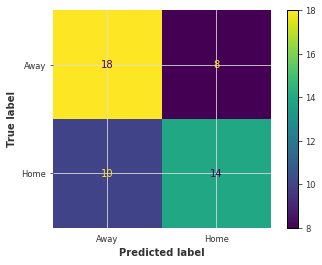

In [19]:
# Testing XGBoost Model without using Health Labels
# Target Accuracy is 68% since Vegas spread favorite wins ~68% of the time
print(f'Baseline Test Accuracy: {accuracy_score(test_df.winner, model.predict(test_df.iloc[:,3:-1])) * 100:.0f}%')
ConfusionMatrixDisplay(confusion_matrix(test_df.winner, model.predict(test_df.iloc[:,3:-1])), display_labels=['Away', 'Home']).plot()
plt.show()

Apply Health Labels to Statistics
This is accomplished by multiplying each player's health by their statistics before aggregation

In [20]:
better_test_df = pd.read_csv('labeled_health_multiplier.csv')

Optimal Health Labeled Accuracy: 70%
Better Than Spread!


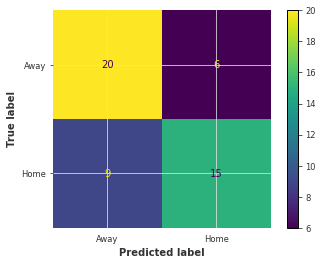

In [21]:
accuracy = accuracy_score(test_df.winner, model.predict(better_test_df.iloc[:,3:]))
print(f'Optimal Health Labeled Accuracy: {accuracy * 100:.0f}%')
print("Better Than Spread!" if accuracy > .68 else "Needs Improvement")
ConfusionMatrixDisplay(confusion_matrix(test_df.winner, model.predict(better_test_df.iloc[:,3:])), display_labels=['Away', 'Home']).plot()
plt.show()

# Health Labeling Model
### N-Beats Model

Training: Trained on x players entire 2022 season
Features:
   * Endogenous Variable: Health
   * Exogenous Variables: Minutes Played, Distance Traveled, Injured, Covid, (Days off by virtue of time series)

In [23]:
file = 'nbeats_v1.pt'; get_file(file)
health_model = NBEATSModel.load(file)
input_width = health_model.input_chunk_length

In [24]:
with open('ts_training.pkl', 'rb') as f:
    data = pickle.load(f)
with open('ts_covariates.pkl', 'rb') as f:
    covs = pickle.load(f)

2022-09-26 08:45:33 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-09-26 08:45:33 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-09-26 08:45:33 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-09-26 08:45:33 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-09-26 08:45:33 pytorch_lightning.loggers.tensorboard WARNING: Missing logger folder: /Users/chasecotton/ml-covid-nba/demos/lightning_logs


Predicting: 0it [00:00, ?it/s]

R2 Score AR: 0.9784688491245318
R2 Score 1S: 0.9983825618779192


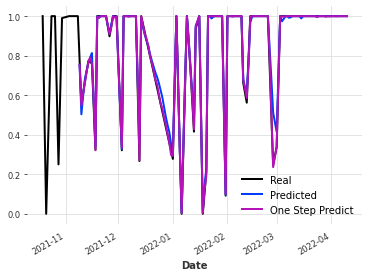

In [25]:
index = 4
y_pred = health_model.predict(n=len(data[-index]) - input_width, series=data[-index][:input_width], past_covariates=covs[-index], verbose=False, trainer=Trainer())
y_pred = y_pred.map(lambda ts, x: np.clip(x, 0, 1))
data[-index].plot(label="Real")
y_pred.plot(label="Predicted")
one_step_pred = standard_predict(health_model, data[-index], covs[-index], input_width)
one_step_pred = one_step_pred.map(lambda ts, x: np.clip(x, 0, 1))
one_step_pred.plot(label='One Step Predict')
print(f'R2 Score AR: {r2_score(data[-index][input_width:].values(), y_pred.values())}')
print(f'R2 Score 1S: {r2_score(data[-index][input_width:].values(), one_step_pred.values())}')

R2 Score AR: -0.46996277824231725
R2 Score 1S: 0.8090419852461054


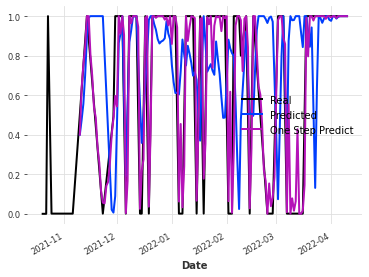

In [33]:
index = 5
y_pred = health_model.predict(n=len(data[-index]) - input_width, series=data[-index][:input_width], past_covariates=covs[-index], verbose=False, trainer=Trainer())
y_pred = y_pred.map(lambda ts, x: np.clip(x, 0, 1))
data[-index].plot(label="Real")
y_pred.plot(label="Predicted")
one_step_pred = standard_predict(health_model, data[-index], covs[-index], input_width)
one_step_pred = one_step_pred.map(lambda ts, x: np.clip(x, 0, 1))
one_step_pred.plot(label='One Step Predict')
print(f'R2 Score AR: {r2_score(data[-index][input_width:].values(), y_pred.values())}')
print(f'R2 Score 1S: {r2_score(data[-index][input_width:].values(), one_step_pred.values())}')

R2 Score AR: -1.7945616450180157
R2 Score 1S: 0.5140606096855026


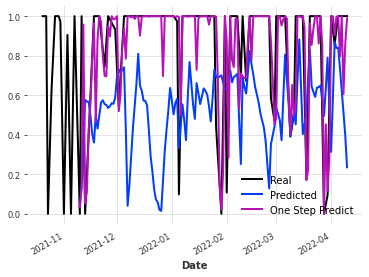

In [34]:
index = 3
y_pred = health_model.predict(n=len(data[-index]) - input_width, series=data[-index][:input_width], past_covariates=covs[-index], verbose=False, trainer=Trainer())
y_pred = y_pred.map(lambda ts, x: np.clip(x, 0, 1))
data[-index].plot(label="Real")
y_pred.plot(label="Predicted")
one_step_pred = standard_predict(health_model, data[-index], covs[-index], input_width)
one_step_pred = one_step_pred.map(lambda ts, x: np.clip(x, 0, 1))
one_step_pred.plot(label='One Step Predict')
print(f'R2 Score AR: {r2_score(data[-index][input_width:].values(), y_pred.values())}')
print(f'R2 Score 1S: {r2_score(data[-index][input_width:].values(), one_step_pred.values())}')